# Test 


# 1. Import der benötigten Packete und des Datenbezugs

In [1]:
import FINE as fn

import pandas as pd
import numpy as np


## Pakete zur Visualisierung

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
## Import Funktion getData

In [4]:
from getData_H1_2021_NP import get_data

In [5]:
data, profile= get_data()

Error: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'DWD_temperature'
Error: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'DWD_solar'
      Connection Car to Wallbox 
0                              1
1                              1
2                              1
3                              1
4                              1
...                          ...
8755                           1
8756                           1
8757                           1
8758                           1
8759                           1

[8760 rows x 1 columns]


# 2. Erstellen der Energy Model Instanzen

In [6]:
# H1 = Haushalt
# electricity = Strom
# ev_electricity = Strom der in das E-Atuo gespeißt wird oder aus der Fahrzeugbatterie bei V2G entnommen wird
# pv_electricity = Strom der von der Solaranlage erzeugt wird
# SG = Saubere Geschirr
# SW = Schmutzige Wäsche
# SWN = Saubere Wäsche Nass
# SWT = Saubere Wäsche Trocken 

In [7]:
esM = fn.EnergySystemModel(
    locations={"H1"},
    commodities={"electricity", "ev_electricity0", "geschirr", "nasse_wäsche"}, 
    commodityUnitsDict={"electricity": r"KW$_{el}$", "ev_electricity0": r"KW$_{el}$", "geschirr": r"SG", "nasse_wäsche": r"SWN"},
    numberOfTimeSteps=8760,
    hoursPerTimeStep=1,
    costUnit="1 Euro",
    lengthUnit="m",
    verboseLogLevel=0,
)

# 3. Quellen

## Strombezug

In [8]:
# positive Preise -> Strombezugskosten
esM.add(
    fn.Source(
        esM = esM,
        name = "Import_positive",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["positive_rate_max_import"]["H1"],
        commodityCostTimeSeries = data["positive_prices_import"]["H1"]
    )
)

# negative Preise -> Erträge aus Strombezug
esM.add(
    fn.Source(
        esM = esM,
        name = "Import_negative",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["negative_rate_max_import"]["H1"],
        commodityRevenueTimeSeries = data["negative_prices_import"]["H1"]
    )
)

# Conversion

## Geschirrspühler 

In [9]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Geschirrspühler",
        physicalUnit= r"SG",
        commodityConversionFactors={"electricity": -0.97, "geschirr": 1}
    )
)    

## Speicher

In [10]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Geschirr Storage",
        commodity="geschirr",
        chargeEfficiency=1,
        dischargeEfficiency=1,
        chargeRate=1,
        dischargeRate=1,
        capacityMax=1,
    )
) 

## Demand Geschirr 

In [11]:
esM.add(
    fn.Sink(
        esM=esM,
        name="SG_Demand",
        commodity="geschirr",
        hasCapacityVariable=False,
        #operationRateFix=data["H1_Geschirr"]["Demand Basic"] #Für nicht Variable Nachfrage bzw. für Stunden, an denen das Geschirr fertig sein soll
        operationRateFix=data["H1_Geschirr"]["Demand Var"] #Für Variablen Einsatz, Demand für sauberes Geschirr wird auf 20:00 Uhr gesetzt, alles andere variabel
    )
)

# 5. Optimization

In [12]:
# esM.aggregateTemporally(numberOfTypicalPeriods=7)


In [13]:
esM.optimize(timeSeriesAggregation=False, solver="gurobi")

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.4937 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2488 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.0105 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.5065 sec)

		(0.0000 sec)

Declaring objective function...
		(9.0524 sec)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-21
Read LP format model from file C:\Users\fl5004\AppData\Local\Temp\tmpgkdoy0qq.pyomo.lp
Reading time = 0.12 seconds
x1: 87614 rows, 61337 columns, 201508 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 3

C:\Users\fl5004\miniforge3\envs\fine\lib\site-packages\FINE\storage.py:1969: UserWarning: Charge and discharge at the same time for component Geschirr Storage
  warnings.warn(


for StorageModel ...  (1.3155sec)
		(7.8815 sec)



# 6. Results

In [14]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

H1
Component       Property        Unit                     
Import_positive NPVcontribution [1 Euro]         57.36937
                TAC             [1 Euro/a]       57.36937
                capacity        [KW$_{el}$]          0.97
                commissioning   [KW$_{el}$]          0.97
                commodCosts     [1 Euro/a]       57.36937
                operation       [KW$_{el}$*h/a]    211.46
                                [KW$_{el}$*h]      211.46
SG_Demand       operation       [SG*h/a]            218.0
                                [SG*h]              218.0

In [15]:
fn.standardIO.writeOptimizationOutputToExcel(esM, outputFileName = "H1 Geschirrspüler Dynamisch 2021") 


Writing output to Excel... 
	Processing SourceSinkModel ...
	Processing ConversionModel ...
	Processing StorageModel ...
	Saving file...
Done. (6.0471 sec)


In [16]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

H1
Component       Property      Unit           
Geschirrspühler capacity      [SG]        1.0
                commissioning [SG]        1.0
                operation     [SG*h/a]  218.0
                              [SG*h]    218.0

## Visualising the individual components

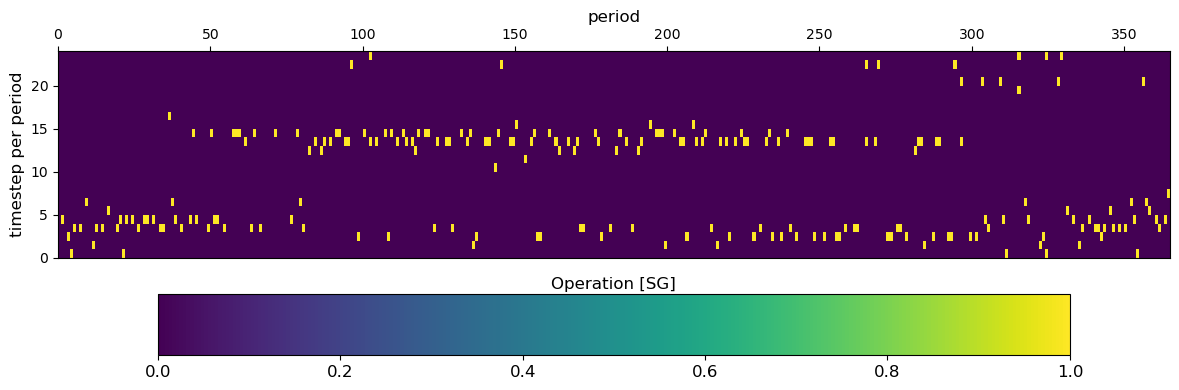

In [17]:
fig, ax = fn.plotOperationColorMap(esM, "Geschirrspühler", "H1")